# Reinforcement Learning (DQN) Tutorial

This code shows how to use PyTorch to train a Deep Q Learning Network (DQN) agent on the CartPole-v1 task from OpenAI's Gymnasium. This is based off the tutorial provided here:

https://docs.pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

The original DQN paper is [here](https://arxiv.org/abs/1312.5602)


## Task

The agent has to decide between two actions - moving the cart left or right - so that the pole attached to it stays upright. You can find more information about the environment and other more challenging environments at Gymnasium’s website.

![CartPole](./Images/cartpole.gif "CartPole")

As the agent observes the current state of the environment and chooses an action, the environment transitions to a new state, and also returns a reward that indicates the consequences of the action. In this task, rewards are +1 for every incremental timestep and the environment terminates if the pole falls over too far or the cart moves more than 2.4 units away from center. This means better performing scenarios will run for longer duration, accumulating larger return.

The CartPole task is designed so that the inputs to the agent are 4 real values representing the environment state (position, velocity, etc.). We take these 4 inputs without any scaling and pass them through a small fully-connected network with 2 outputs, one for each action. The network is trained to predict the expected value for each action, given the input state. The action with the highest expected value is then chosen.

In [20]:
# Pip install gymnasium. This is a fork of the original OpenAI Gym library.
!pip install gymnasium[classic_control]


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
# Import required libraries
import gymnasium as gym
import math
import random
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

# Torch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [5]:
# Set environment
env = gym.make("CartPole-v1")

In [6]:
# Setup matplotlib correctly
is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

In [8]:
# GPU detection
device = torch.device(
    "cuda" if torch.cuda.is_available() else 
    "mps" if torch.backends.mps.is_available() else 
    "cpu"
)

print(f"Using device: {device}")

Using device: cuda


In [9]:
# To ensure reproducibility during training, you can fix the random seeds
# by uncommenting the lines below. This makes the results consistent across
# runs, which is helpful for debugging or comparing different approaches.
#
# That said, allowing randomness can be beneficial in practice, as it lets
# the model explore different training trajectories.

seed = 42
random.seed(seed)
torch.manual_seed(seed)
env.reset(seed=seed)
env.action_space.seed(seed)
env.observation_space.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

## Replay Memory

We'll be using experience replay memory for training the DQN. This stores the transitions that the agent observes. This transition data can be reused later. By sampling from it randomly, the transitions that build up a batch are de-correlated from each other. It has been shown to stabilize and improve DQN training.

We need two classes to enable this:
- `Transition`: A named tuple representing a single transition in the environment. It maps (state, action) pairs to their (next_state, reward) results. The state is the screen difference image as described later on.
- `ReplayMemory`: A cyclic buffer of bounded size that holds transitions observed recently. Implements a `.sample()` method for selecting a random batch of transitions for training.

In [11]:
Transition = namedtuple('Transition',
                        ('state', 'action',
                        'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        # Save a transition
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

## DQN Algorithm

The environment is deterministic. All equations presented here are then formulated deterministically for the sake of simplicity. In RL literature, they would also contain expectations over stochastic transitions in the environment. 

The aim is to train a policy that tries to maximise the discounted, cumulative reward ($R_{t_0} = \sum^{\infty}_{t=t_0} \gamma^{t-t_0} r_t$). $R_{t_0}$ is the return. The discount $\gamma$ should be constant between 0 and 1 and ensures that the cumulative sum converges. A lower $\gamma$ makes the rewards from the uncertain far future less important for our agent than the ones in the near future that it can be fairly confident about. It encourages agents to collect reward closer in time than equivalent rewards that are temporally far away in the future. 

The main idea behind Q-learning is that if we have a function $Q* : \text{State} \times \text{Action} \rightarrow \mathcal{R}$, that could tell us what the return would be. If we were to take an action in a given state then we could construct a policy that maximises the rewards:

$\pi^{*}(s) = arg \underset{a}{max} \ Q^{*}(s, a)$

However, given limited knowledge of the world, we do not have access to $Q^{*}$. Since neural networks are universal function approximators, we can create a deep network and train it to resemble $Q^{*}$. For the training update rule, we'll use a fact that every Q function for some policy obeys the Bellman equation:

$Q^{\pi} (s, a) = r + \gamma Q^{\pi} (s', \pi(s')) $

The difference between the two sides of the equality is known as the temporal difference error, $\delta$:

$\delta = Q(s, a) - (r + \gamma \ \underset{a}{\overset{'}{max}} \ Q(\overset{'}{s}, a)) $

To minimise this error, we use the Huber loss. The Huber loss acts like the MSE loss function when the error is small, but like MAE when the error is large. This makes it more robust to outliers when the estimates of $Q$ are very noisy. We calculate this over a batch of transitions, $B$, samples from the replay memory:

$\mathcal{L} = \frac{1}{|B|} \underset{(s,a,s',r) \in B}{\sum}$

Where:

$\mathcal{L}(\delta) = \begin{cases} \frac{1}{2} \delta^2 & \text{for} |\delta| \leq 1, \\ |\delta| - \frac{1}{2} & \text{otherwise.} \end{cases} $



## Q-network

The model used here is a feed-forward neural network that takes in the difference between the current and previous screen patches. It has two outputs, $Q(s, \text{left})$ and $Q(s, \text{right})$ where $s$ is the input to the network. The network is trying to predict the expected return of taking each action given the current input.

In [14]:
# Q-Network (FFNN)

class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with one element to determine next action.
    # Called with a batch during optimisation.
    # Returns tensor([[left0exp, right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)


## Training

### Hyperparameters and utilities

This cell instantiates the model, optimiser and defines utilities:
- `select_action`: Will select an action according to an epsilon greedy policy. Simply put, we'll sometimes use our model for choosing the action and sometimes we will sample uniformly. The probability of choosing a random action will start at `EPS_START` and will decay exponentially towards `EPS_END`. `EPS_DECAY` controls the rate of the decay.
- `plot_durations`: A helper for plotting the duration of episodes, along with an average over the last 100 episodes (the measure used in the official evaluations). This plot will be underneath the cell containing the main training loop, and we will update after every episode.

In [12]:
BATCH_SIZE = 128      # BATCH_SIZE is the number of transitions sampled from the replay buffer
GAMMA      = 0.99     # GAMMA is the discount factor as mentioned in the previous section
EPS_START  = 0.90     # EPS_START is the starting value of epsilon
EPS_END    = 0.01     # EPS_END is the final value of epsilon
EPS_DECAY  = 2500     # EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
TAU        = 0.005    # TAU is the update rate of the target network
LR         = 3e-4     # LR is the learning rate of the ``AdamW`` optimizer

In [15]:
# Get number of actions from gym action space
n_actions = env.action_space.n

# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

# Initialize policy and target networks
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

# Define optimizer, memory and steps
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)
steps_done = 0

In [16]:
# Define the action selection
def select_action(state):

    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1

    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

In [ ]:
# Plot episode durations
episode_durations = []

def plot_durations(show_result=False):
    
    # Initialise figure
    plt.figure(1)

    # Get time durations
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Balancing Duration')
    plt.plot(durations_t.numpy())
    
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

## Training loop

The code is now ready to train the model.

This is the `optimise_model` function that performs a single step of the optimisation. It first samples a batch, concatenates all the tensors into a single one, computes $Q (s_t, a_t)$ and $V(s_{t+1}) = max_a Q(s_{t+1}, a)$ and combines them into our loss (Huber). We set $V(s) = 0$ if $s$ is a terminal state. We also use a target network to comput $V(s_{t+1})$ for added stability. The target network is updated every step with a soft update controlled by the hyperparameter `TAU`, which has been defined above. 

In [18]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)

    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

## Main Training Loop

At the beginning, we reset the environment and obtain the initial `state` tensor. Then, we sample an action, execute it, observe the next state and the reward (always 1), and optimise the model once. When the episode ends (our model fails), we restart the loop.

Belowm `num_episodes` is set to 600 if a GPU is availablem otherwise 50 are used to it does not take too long on a slower CPU. However, 50 episodes is insufficient to get good performance on CartPole. You should see the model consistently achieve 500 steps within 600 training episodes.

Training RL agents can be a noisy process, so restarting training can produce better results if convergence is not observed. 

Complete


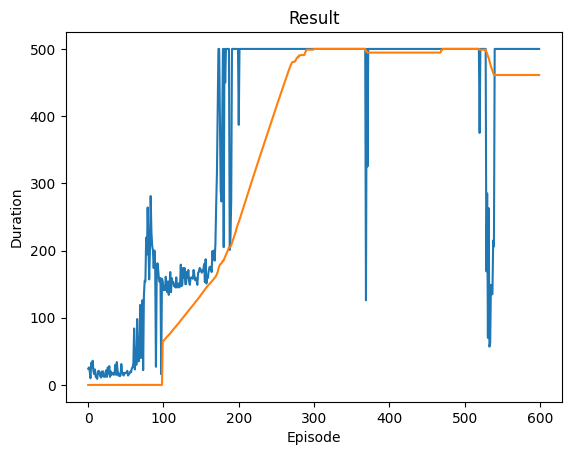

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [19]:
# Set the number of episodes (GPU or CPU detection)
if torch.cuda.is_available() or torch.backends.mps.is_available():
    num_episodes = 600
else:
    num_episodes = 50


# Training iterations (MAIN LOOP)
for i_episode in range(num_episodes):

    # Initialise the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

    # Take actions
    for t in count():

        # Select action
        action = select_action(state)
        
        # Execute action in the environment
        observation, reward, terminated, truncated, _ = env.step(action.item())

        # Get the reward (correct format)
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        # Progress to next state (if applicable)
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        # If done, plot and break loop
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

# Exit commands
print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

Actions are chosen either randomly or based on a policy, getting the next step sample from the gym environment. We record the results in the replay memory and also run optimization step on every iteration. Optimization picks a random batch from the replay memory to do training of the new policy. The “older” target_net is also used in optimization to compute the expected Q values. A soft update of its weights are performed at every step.

Here is the diagram that illustrates the overall resulting data flow.

![Overview of RL framework](./Images/Overview.png "Overview of RL framework")